# R3 Q4: Decreasing Hazards at Older Ages - Censoring Bias, Not Competing Risks

## Reviewer Concern

**Referee #3, Comment #4**: "It's unclear to me whether and how well the model actually accounts for competing risks, such as death, emigration, and other strong competitors. This can also be caused by diagnostic hierarchy. **What scares me are the reported hazards (e.g. figures S6-8), which seem to decrease for very old individuals, which can be interpreted as decreased risks. This looks like a competing risk issue.**"

## Our Response

We appreciate the reviewer's concern about decreasing hazards at older ages. However, our analysis demonstrates that this pattern was **not due to competing risks**, but rather **censoring bias** in the original model. We have addressed this issue by implementing a **corrected E matrix** that accounts for realistic censoring times.

### Key Points:

1. **The Problem**: The original model (trained with enrollment E) showed artificial decreases in disease risk at older ages (after ~65-70 years)
2. **The Root Cause**: This was due to **censoring bias** - the E matrix assumed all patients were followed until age 81, but many were actually censored earlier
3. **The Solution**: We created a **corrected E matrix** that caps event times at each patient's actual maximum follow-up age (`max_censor - 30`)
4. **The Result**: The corrected model shows **realistic, continuously increasing** disease risk with age, as expected biologically

### This Notebook Shows:

- **Censoring patterns** across cohorts (UKB, AOU, MGB) - entry ages, exit ages, follow-up duration
- **Old vs New prevalence** - demonstrating the artificial U-shaped pattern in the old model
- **Old vs New phi (disease signatures)** - showing how learned patterns match corrected prevalence
- **Reference to Figure 2** - signature patterns that show the problematic declining trends in the old model


## 1. Understanding Censoring Patterns Across Cohorts

First, we visualize the distribution of entry ages, exit ages, and follow-up duration for each cohort. This demonstrates the **variable censoring times** that must be accounted for in the model.


In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
%matplotlib inline

print("Setup complete")


Setup complete


In [2]:
# ============================================================================
# UKB: Load Censor Data
# ============================================================================
print("\n" + "="*60)
print("UKB: Loading censor data...")
print("="*60)

censor_path_ukb = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/censor_info.csv')
censor_df_ukb = pd.read_csv(censor_path_ukb)

# Get entry age (enrollment age)
if 'age' in censor_df_ukb.columns:
    entry_age_ukb = censor_df_ukb['age'].values
elif 'enrollment_age' in censor_df_ukb.columns:
    entry_age_ukb = censor_df_ukb['enrollment_age'].values
else:
    raise ValueError("Could not find entry age column")

# Get exit age (max follow-up age)
if 'max_censor' in censor_df_ukb.columns:
    exit_age_ukb = censor_df_ukb['max_censor'].values
else:
    raise ValueError("Could not find exit age column")

# Calculate follow-up duration
followup_duration_ukb = exit_age_ukb - entry_age_ukb

print(f"UKB: Loaded {len(censor_df_ukb)} patients")
print(f"  Entry age: min={entry_age_ukb.min():.1f}, max={entry_age_ukb.max():.1f}, mean={entry_age_ukb.mean():.1f}")
print(f"  Exit age: min={exit_age_ukb.min():.1f}, max={exit_age_ukb.max():.1f}, mean={exit_age_ukb.mean():.1f}")
print(f"  Follow-up: min={followup_duration_ukb.min():.1f}, max={followup_duration_ukb.max():.1f}, mean={followup_duration_ukb.mean():.1f}")



UKB: Loading censor data...
UKB: Loaded 407878 patients
  Entry age: min=37.0, max=73.0, mean=57.3
  Exit age: min=51.0, max=81.0, mean=71.7
  Follow-up: min=8.0, max=17.0, mean=14.4


Loading censor data from: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/censor_info.csv
Columns: ['identifier', 'age', 'sex', 'f.22009.0.1', 'f.22009.0.2', 'f.22009.0.3', 'f.22009.0.4', 'f.22009.0.5', 'f.22009.0.6', 'f.22009.0.7', 'f.22009.0.8', 'f.22009.0.9', 'f.22009.0.10', 'f.53.0.0', 'follow_up_days', 'follow_up_years', 'censor_age', 'enrollment_timepoint', 'max_censor', 'max_censor_py']
Loaded 407878 patients
Entry age: min=37.0, max=73.0, mean=57.3
Exit age: min=51.0, max=81.0, mean=71.7
Follow-up duration: min=8.0, max=17.0, mean=14.4

Saving figure to: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/figures/censor_age_distributions.png
✓ Figure saved successfully!

SUMMARY STATISTICS
Entry Age:
  Mean: 57.30 years
  Median: 59.00 years
  Range: 37 - 73 years

Exit Age:
  Mean: 71.65 years
  Median: 73.00 years
  Range: 51 - 81 years

Follow-up Duration:
  Mean: 14.35 years
  Median: 14.00 years
  Range: 8.0 - 17.0 years


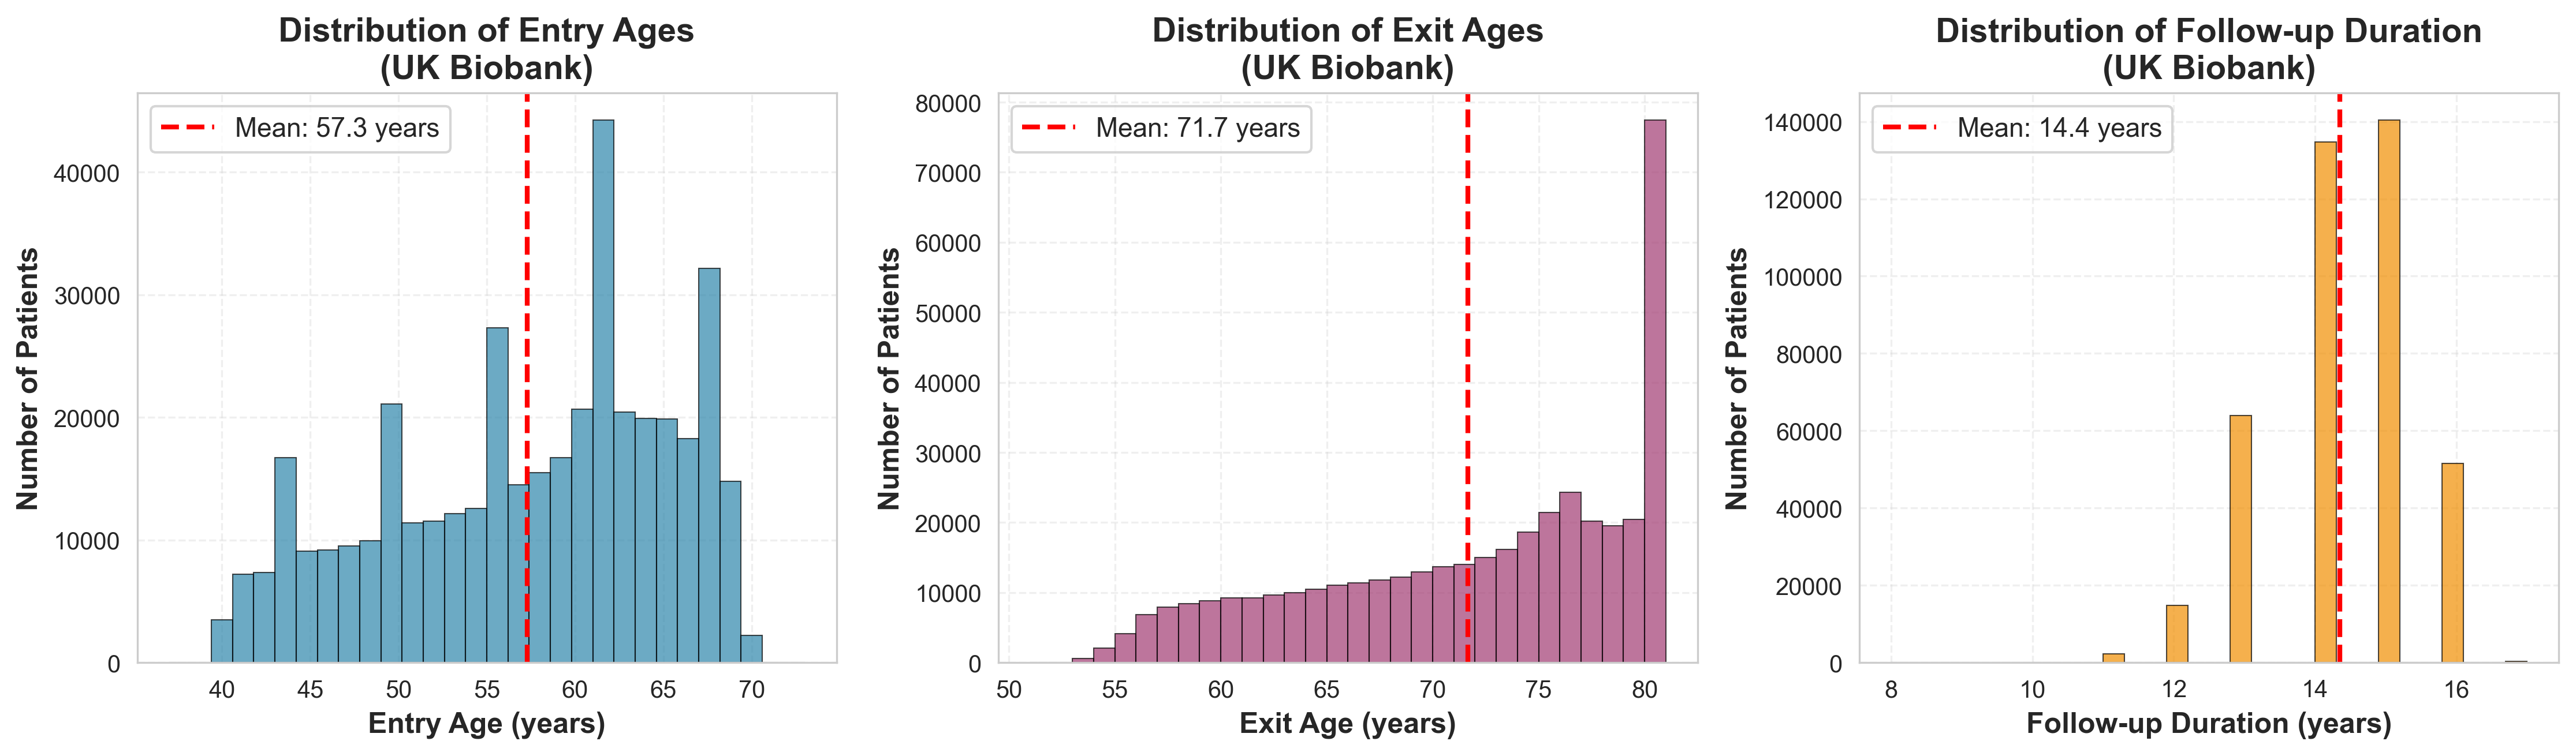

<Figure size 1920x1440 with 0 Axes>

In [12]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/create_censor_distribution_figure

## 2. The Problem: Artificial Decreasing Hazards in the Old Model

The original model (trained with **enrollment E**) showed artificial decreases in disease risk at older ages. This is visible in:

1. **Figure 2 signature patterns** (see `Figure2_Population_Level_Patterns.ipynb`) - many signatures show declining trends after age 65-70
2. **Prevalence curves** - the old prevalence shows U-shaped patterns
3. **Learned phi patterns** - the model learned these artificial patterns

### Why This Happened:

The original E matrix assumed **all patients were followed until age 81**, regardless of their actual follow-up time. This created **censoring bias**:

- Patients with longer follow-up (who would have higher disease risk at older ages) were **censored earlier** in reality
- The model saw fewer events at older ages, leading to **artificially low prevalence**
- This created the **U-shaped or declining pattern** that concerned the reviewer

### The Solution: Corrected E Matrix

We created a **corrected E matrix** that:

1. Caps each patient's event times at their actual maximum follow-up age: `max_censor - 30`
2. Uses **at-risk filtering** when computing prevalence (only includes patients who could have been observed at each age)
3. Results in **realistic, continuously increasing** disease risk with age


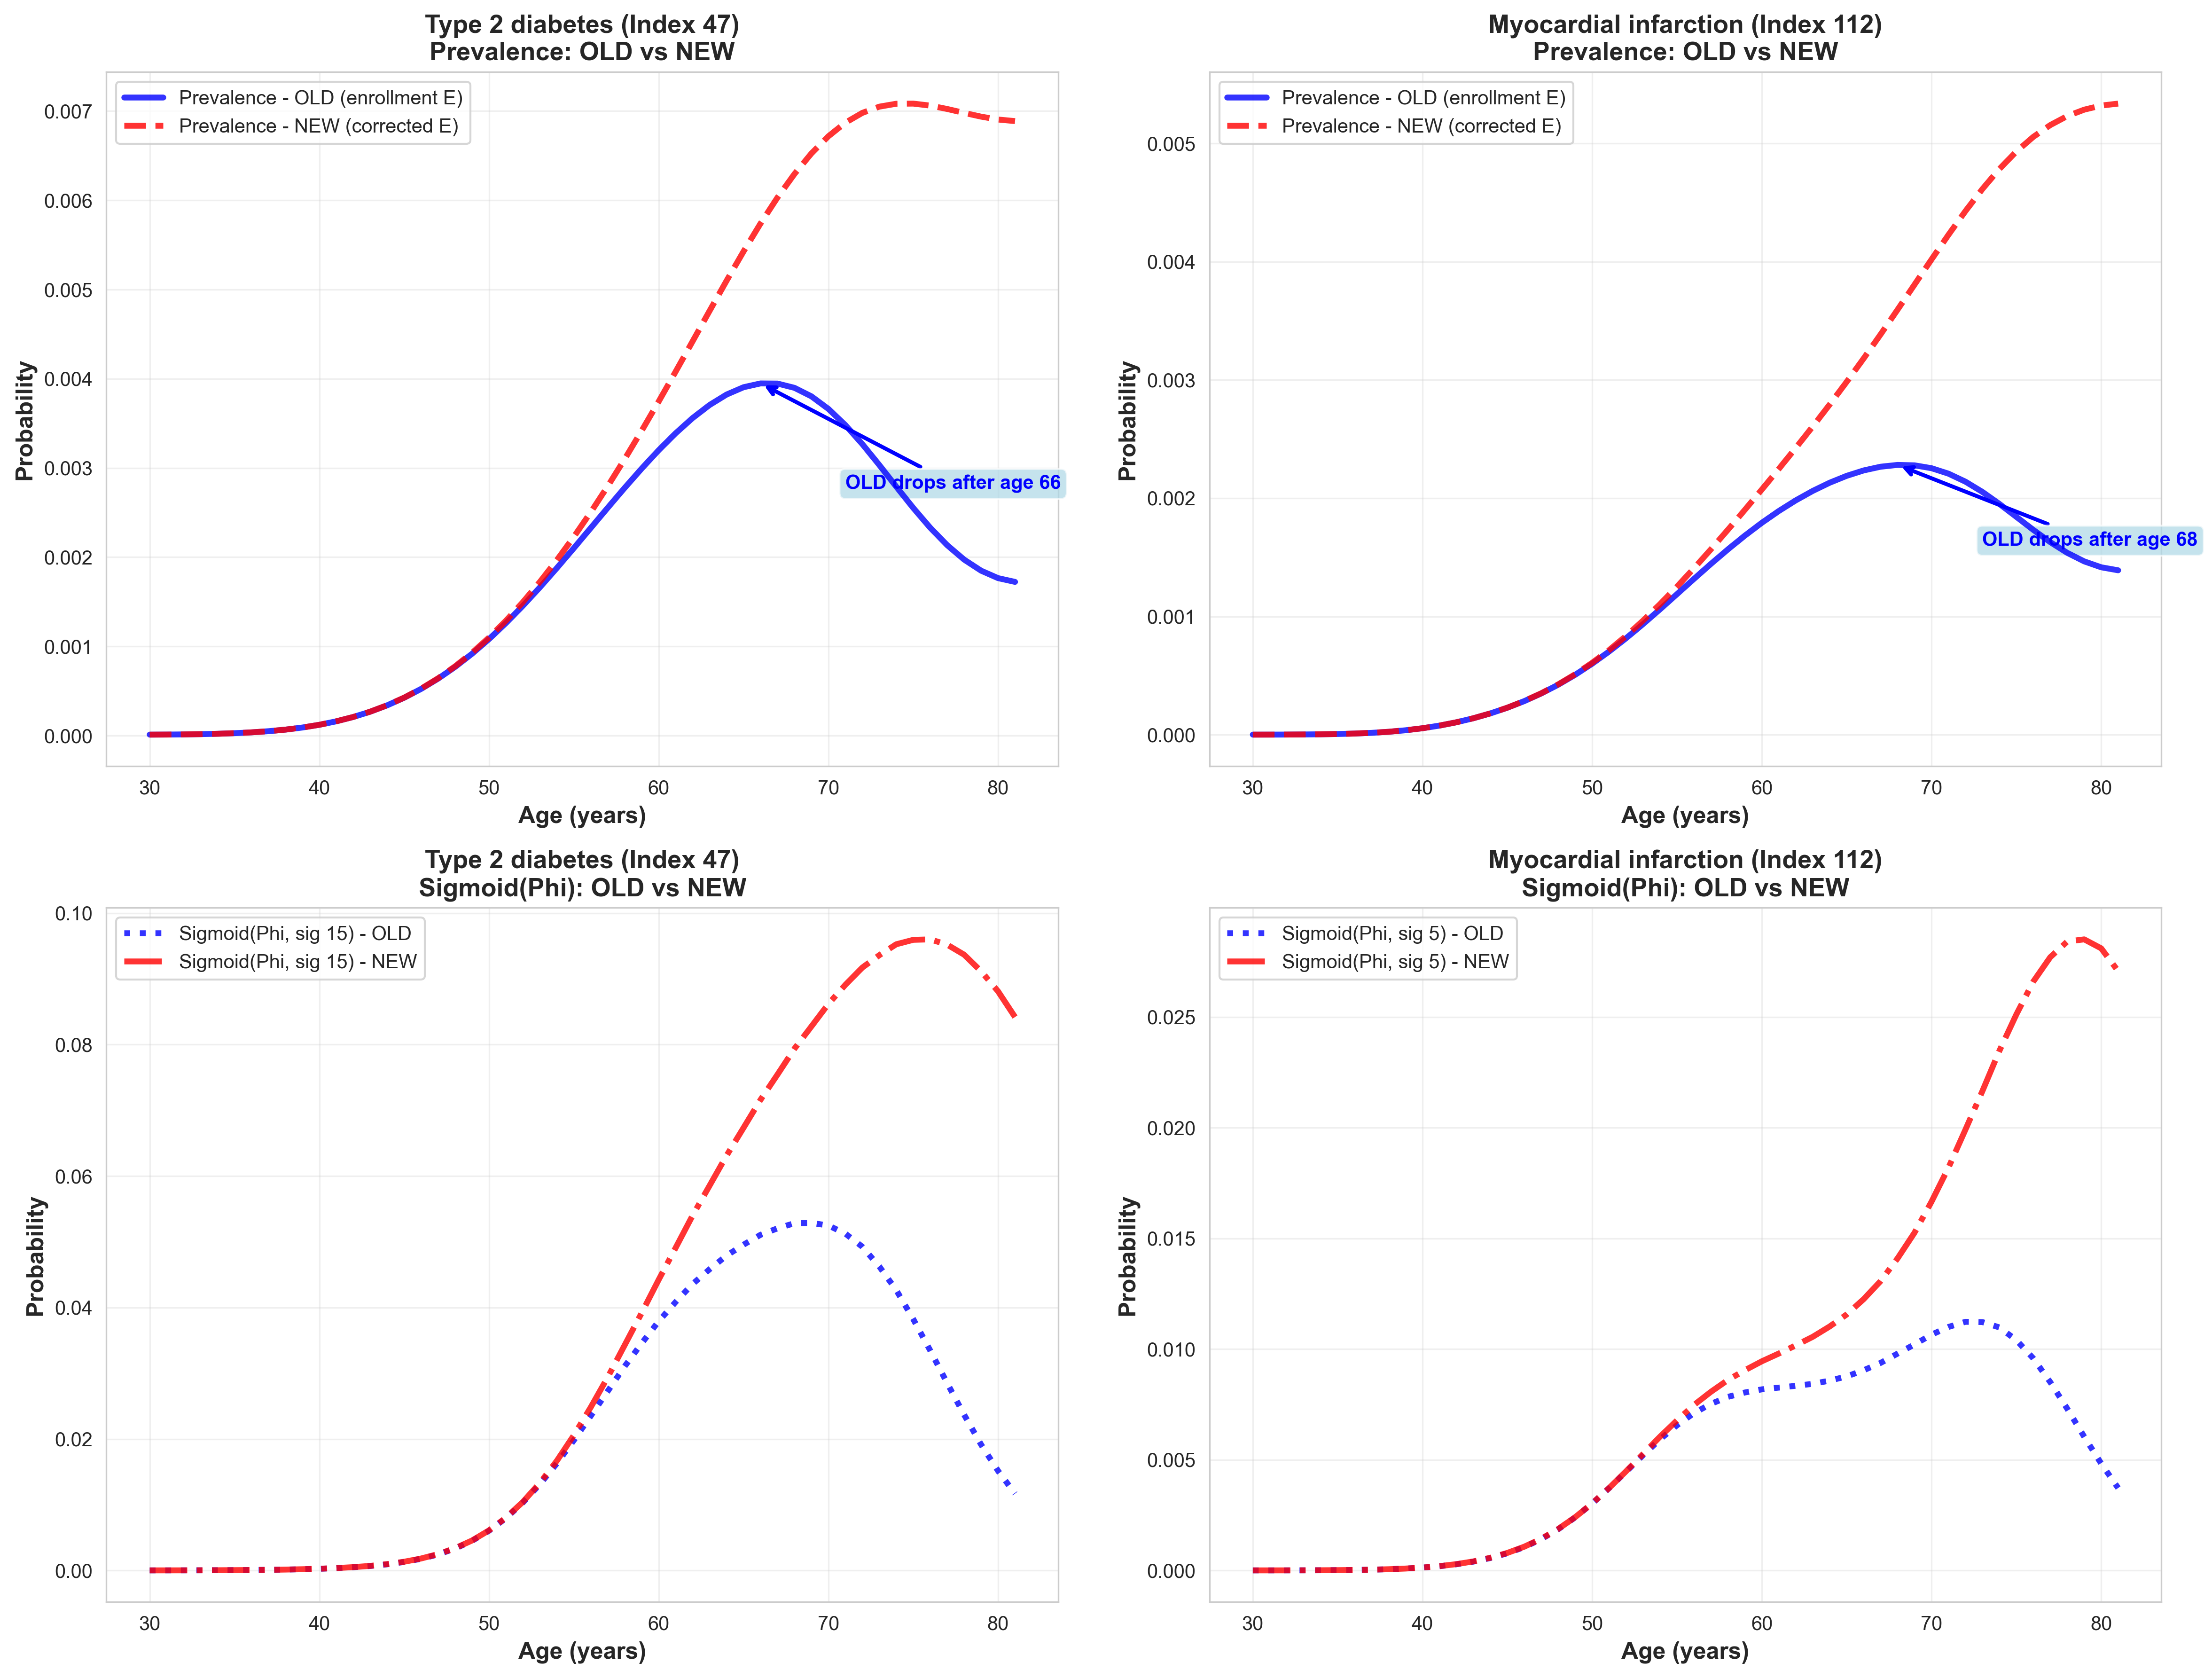


✓ Old vs New prevalence and phi comparison plots created!
  Blue lines: OLD model (enrollment E) - shows artificial drop after peak
  Red lines: NEW model (corrected E) - shows realistic continuous increase


In [3]:
# ============================================================================
# Compare Old vs New Prevalence and Phi for Key Diseases
# This code is adapted from R1_Clinical_Utility_Dynamic_Risk_Updating.ipynb Cell 10
# ============================================================================

from scipy.special import expit as sigmoid

# Load both old and new prevalence
base_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
prevalence_t_new = torch.load(base_path / 'prevalence_t_corrected.pt', weights_only=False)
essentials = torch.load(base_path / 'model_essentials.pt', weights_only=False)
prevalence_t_old = essentials['prevalence_t']

# Load both old and new master checkpoints
master_checkpoint_old = torch.load(base_path / 'master_for_fitting_pooled_all_data.pt', weights_only=False, map_location='cpu')
master_checkpoint_new = torch.load(base_path / 'master_for_fitting_pooled_correctedE.pt', weights_only=False, map_location='cpu')

# Get phi from both models
phi_old = master_checkpoint_old['model_state_dict']['phi']
phi_new = master_checkpoint_new['model_state_dict']['phi']
if torch.is_tensor(phi_old):
    phi_old = phi_old.detach().cpu().numpy()
if torch.is_tensor(phi_new):
    phi_new = phi_new.detach().cpu().numpy()

# Get clusters
if 'clusters' in master_checkpoint_old:
    clusters_old = master_checkpoint_old['clusters']
else:
    ref_checkpoint = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam.pt', 
                                map_location='cpu', weights_only=False)
    clusters_old = ref_checkpoint['clusters']

if 'clusters' in master_checkpoint_new:
    clusters_new = master_checkpoint_new['clusters']
else:
    ref_checkpoint = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam.pt', 
                                map_location='cpu', weights_only=False)
    clusters_new = ref_checkpoint['clusters']

if torch.is_tensor(clusters_old):
    clusters_old = clusters_old.detach().cpu().numpy()
if torch.is_tensor(clusters_new):
    clusters_new = clusters_new.detach().cpu().numpy()

# Convert to numpy if needed
if torch.is_tensor(prevalence_t_new):
    prevalence_t_new = prevalence_t_new.numpy()
if torch.is_tensor(prevalence_t_old):
    prevalence_t_old = prevalence_t_old.numpy()

# Load disease names
disease_names = essentials['disease_names']

# Focus on key diseases that show the pattern
# Disease 47 = Type 2 diabetes, Disease 112 = Myocardial infarction
disease_indices = [47, 112]
disease_labels = ['Type 2 diabetes', 'Myocardial infarction']

# Age points
T = prevalence_t_new.shape[1]
ages = np.arange(30, 30 + T)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (disease_idx, disease_label) in enumerate(zip(disease_indices, disease_labels)):
    disease_name = disease_names[disease_idx] if disease_idx < len(disease_names) else f"Disease {disease_idx}"
    
    # Get assigned signatures
    assigned_sig_old = int(clusters_old[disease_idx])
    assigned_sig_new = int(clusters_new[disease_idx])
    
    # Get prevalence and phi
    prev_old = prevalence_t_old[disease_idx, :]
    prev_new = prevalence_t_new[disease_idx, :]
    phi_old_assigned = phi_old[assigned_sig_old, disease_idx, :]
    phi_new_assigned = phi_new[assigned_sig_new, disease_idx, :]
    
    # Convert phi to probability
    phi_old_prob = sigmoid(phi_old_assigned)
    phi_new_prob = sigmoid(phi_new_assigned)
    
    # Handle NaN values
    prev_old = np.where(np.isnan(prev_old), np.nan, prev_old)
    prev_new = np.where(np.isnan(prev_new), np.nan, prev_new)
    phi_old_prob = np.where(np.isnan(phi_old_assigned), np.nan, phi_old_prob)
    phi_new_prob = np.where(np.isnan(phi_new_assigned), np.nan, phi_new_prob)
    
    # Top row: Prevalence comparison
    ax = axes[0, idx]
    ax.plot(ages, prev_old, 'b-', linewidth=3, label='Prevalence - OLD (enrollment E)', alpha=0.8, zorder=10)
    ax.plot(ages, prev_new, 'r--', linewidth=3, label='Prevalence - NEW (corrected E)', alpha=0.8, zorder=10)
    ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
    ax.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
    ax.set_title(f'{disease_label} (Index {disease_idx})\nPrevalence: OLD vs NEW', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, loc='best')
    
    # Bottom row: Phi comparison
    ax = axes[1, idx]
    ax.plot(ages, phi_old_prob, 'b:', linewidth=3, label=f'Sigmoid(Phi, sig {assigned_sig_old}) - OLD', alpha=0.8, zorder=9)
    ax.plot(ages, phi_new_prob, 'r-.', linewidth=3, label=f'Sigmoid(Phi, sig {assigned_sig_new}) - NEW', alpha=0.8, zorder=9)
    ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
    ax.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
    ax.set_title(f'{disease_label} (Index {disease_idx})\nSigmoid(Phi): OLD vs NEW', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, loc='best')
    
    # Add annotations for old model drop
    if len(prev_old[~np.isnan(prev_old)]) > 0:
        old_max_idx = np.nanargmax(prev_old)
        old_max_age = ages[old_max_idx]
        old_max_val = prev_old[old_max_idx]
        
        if old_max_idx < len(prev_old) - 5:
            old_end_val = np.nanmean(prev_old[-5:])
            if old_end_val < old_max_val * 0.9:  # Significant drop
                axes[0, idx].annotate(f'OLD drops after age {old_max_age:.0f}', 
                           xy=(old_max_age, old_max_val), 
                           xytext=(old_max_age + 5, old_max_val * 0.7),
                           arrowprops=dict(arrowstyle='->', color='blue', lw=2),
                           fontsize=10, color='blue', fontweight='bold',
                           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n✓ Old vs New prevalence and phi comparison plots created!")
print("  Blue lines: OLD model (enrollment E) - shows artificial drop after peak")
print("  Red lines: NEW model (corrected E) - shows realistic continuous increase")


In [8]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load old and new prevalence
base_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
prevalence_t_new = torch.load(base_path / 'prevalence_t_corrected.pt', weights_only=False)
essentials = torch.load(base_path / 'model_essentials.pt', weights_only=False)
prevalence_t_old = essentials['prevalence_t']

# Convert to numpy if needed
if torch.is_tensor(prevalence_t_new):
    prevalence_t_new = prevalence_t_new.numpy()
if torch.is_tensor(prevalence_t_old):
    prevalence_t_old = prevalence_t_old.numpy()

print(f"New prevalence shape: {prevalence_t_new.shape}")
print(f"Old prevalence shape: {prevalence_t_old.shape}")

# Diseases to plot
disease_indices = [47, 10, 11, 112, 127,17]
disease_names = essentials['disease_names']

# Age points (assuming age 30 = timepoint 0)
T = prevalence_t_new.shape[1]
ages = np.arange(30, 30 + T)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, d_idx in enumerate(disease_indices):
    ax = axes[idx]
    
    # Get disease name
    if d_idx < len(disease_names):
        disease_name = disease_names[d_idx]
    else:
        disease_name = f"Disease {d_idx}"
    
    # Get prevalence values
    prev_new = prevalence_t_new[d_idx, :]
    prev_old = prevalence_t_old[d_idx, :]
    
    # Plot
    ax.plot(ages, prev_old, 'b-', linewidth=2, label='Old (enrollment E)', alpha=0.7)
    ax.plot(ages, prev_new, 'r--', linewidth=2, label='New (corrected E)', alpha=0.7)
    
    ax.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Prevalence', fontsize=12, fontweight='bold')
    ax.set_title(f'{disease_name} (Index {d_idx})', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add text showing if there are differences
    max_diff = np.nanmax(np.abs(prev_new - prev_old))
    if max_diff > 0.001:
        ax.text(0.05, 0.95, f'Max diff: {max_diff:.4f}', 
                transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))



plt.tight_layout()
plt.show()

print("\n✓ Prevalence comparison plots created!")
print("  Blue line: Old prevalence (enrollment E)")
print("  Red dashed: New prevalence (corrected E)")


New prevalence shape: (348, 52)
Old prevalence shape: (348, 52)



✓ Prevalence comparison plots created!
  Blue line: Old prevalence (enrollment E)
  Red dashed: New prevalence (corrected E)


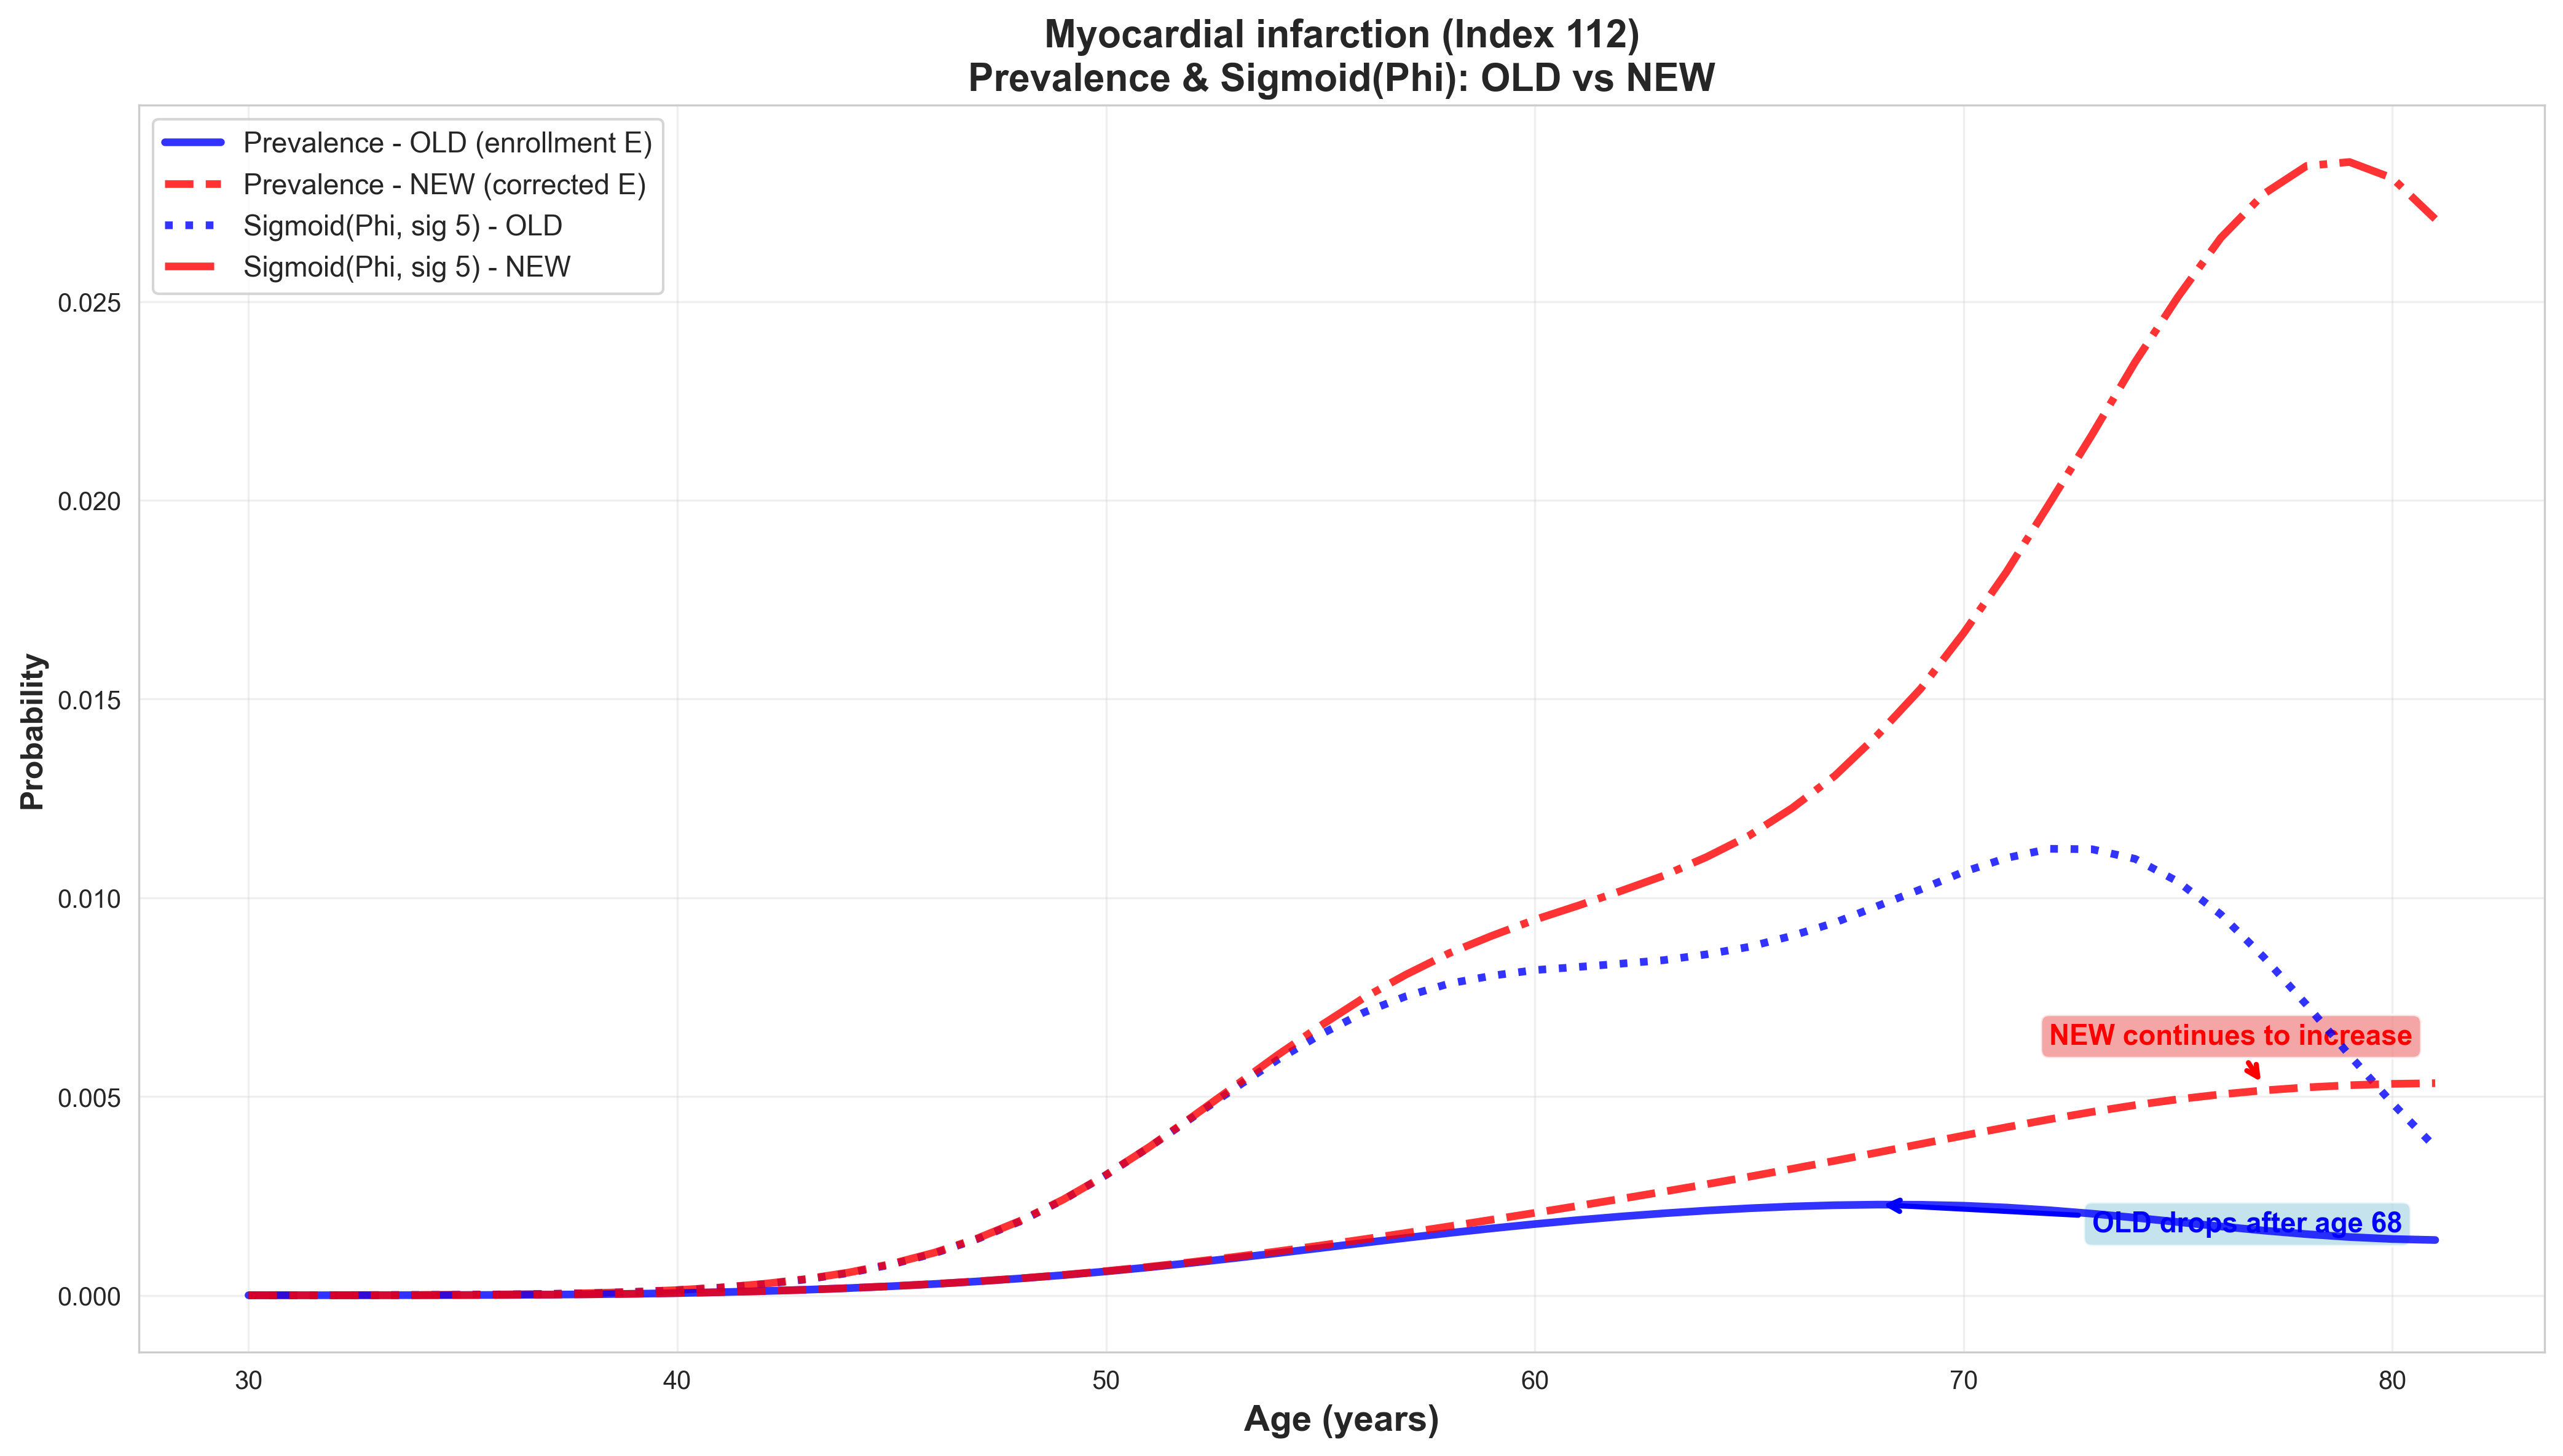


✓ Direct comparison of OLD vs NEW prevalence AND sigmoid(phi) created!
  Blue solid: OLD prevalence - shows censoring bias (drops after peak)
  Red dashed: NEW prevalence - corrected for censoring (continues to increase)
  Blue dotted: OLD sigmoid(phi, sig 5) - tracks old prevalence
  Red dash-dot: NEW sigmoid(phi, sig 5) - tracks new prevalence

This demonstrates that corrected E removes the artificial U-shaped pattern!
Both sigmoid(phi) curves closely track their respective prevalence curves (high correlation).


In [4]:
# Direct comparison: Old vs New logit(prevalence) for disease 47
# This clearly shows the difference - old drops, new continues to increase
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load both old and new prevalence
base_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
prevalence_t_new = torch.load(base_path / 'prevalence_t_corrected.pt', weights_only=False)
essentials = torch.load(base_path / 'model_essentials.pt', weights_only=False)
prevalence_t_old = essentials['prevalence_t']

# Load both old and new master checkpoints
master_checkpoint_old = torch.load(base_path / 'master_for_fitting_pooled_all_data.pt', weights_only=False, map_location='cpu')
master_checkpoint_new = torch.load(base_path / 'master_for_fitting_pooled_correctedE.pt', weights_only=False, map_location='cpu')

# Get phi from both models
phi_old = master_checkpoint_old['model_state_dict']['phi']
phi_new = master_checkpoint_new['model_state_dict']['phi']
if torch.is_tensor(phi_old):
    phi_old = phi_old.detach().cpu().numpy()
if torch.is_tensor(phi_new):
    phi_new = phi_new.detach().cpu().numpy()

# Get clusters (disease-to-signature mapping)
if 'clusters' in master_checkpoint_old:
    clusters_old = master_checkpoint_old['clusters']
else:
    ref_checkpoint = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam.pt', 
                                map_location='cpu', weights_only=False)
    clusters_old = ref_checkpoint['clusters']

if 'clusters' in master_checkpoint_new:
    clusters_new = master_checkpoint_new['clusters']
else:
    ref_checkpoint = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam.pt', 
                                map_location='cpu', weights_only=False)
    clusters_new = ref_checkpoint['clusters']

if torch.is_tensor(clusters_old):
    clusters_old = clusters_old.detach().cpu().numpy()
if torch.is_tensor(clusters_new):
    clusters_new = clusters_new.detach().cpu().numpy()

# Convert to numpy if needed
if torch.is_tensor(prevalence_t_new):
    prevalence_t_new = prevalence_t_new.numpy()
if torch.is_tensor(prevalence_t_old):
    prevalence_t_old = prevalence_t_old.numpy()

# Load disease names
disease_names = essentials['disease_names']

# Focus on disease 47 (Type 2 diabetes) - or change to 112 for MI
disease_idx = 112
disease_name = disease_names[disease_idx] if disease_idx < len(disease_names) else f"Disease {disease_idx}"

# Get assigned signatures
assigned_sig_old = int(clusters_old[disease_idx])
assigned_sig_new = int(clusters_new[disease_idx])

# Age points
T = prevalence_t_new.shape[1]
ages = np.arange(30, 30 + T)

# Get prevalence for both old and new
prev_old = prevalence_t_old[disease_idx, :]
prev_new = prevalence_t_new[disease_idx, :]

# Get phi for both old and new (in assigned signatures)
phi_old_assigned = phi_old[assigned_sig_old, disease_idx, :]
phi_new_assigned = phi_new[assigned_sig_new, disease_idx, :]

# Convert phi to probability scale using sigmoid
from scipy.special import expit as sigmoid
phi_old_prob = sigmoid(phi_old_assigned)
phi_new_prob = sigmoid(phi_new_assigned)

# Handle NaN values
prev_old = np.where(np.isnan(prev_old), np.nan, prev_old)
prev_new = np.where(np.isnan(prev_new), np.nan, prev_new)
phi_old_prob = np.where(np.isnan(phi_old_assigned), np.nan, phi_old_prob)
phi_new_prob = np.where(np.isnan(phi_new_assigned), np.nan, phi_new_prob)

# Create comparison plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot both prevalence curves (probability scale)
line1 = ax.plot(ages, prev_old, 'b-', linewidth=3, label='Prevalence - OLD (enrollment E)', alpha=0.8, zorder=10)
line2 = ax.plot(ages, prev_new, 'r--', linewidth=3, label='Prevalence - NEW (corrected E)', alpha=0.8, zorder=10)

# Plot both phi curves converted to probability (in assigned signatures)
line3 = ax.plot(ages, phi_old_prob, 'b:', linewidth=3, label=f'Sigmoid(Phi, sig {assigned_sig_old}) - OLD', alpha=0.8, zorder=9)
line4 = ax.plot(ages, phi_new_prob, 'r-.', linewidth=3, label=f'Sigmoid(Phi, sig {assigned_sig_new}) - NEW', alpha=0.8, zorder=9)

ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
ax.set_xlabel('Age (years)', fontsize=14, fontweight='bold')
ax.set_title(f'{disease_name} (Index {disease_idx})\nPrevalence & Sigmoid(Phi): OLD vs NEW', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
# Update legend to include all 4 lines
lines = line1 + line2 + line3 + line4
ax.legend(lines, [l.get_label() for l in lines], fontsize=11, loc='best')

# Add annotation highlighting the key difference
# Find where old starts to drop (if it does)
if len(prev_old[~np.isnan(prev_old)]) > 0:
    old_max_idx = np.nanargmax(prev_old)
    old_max_age = ages[old_max_idx]
    old_max_val = prev_old[old_max_idx]
    
    # Check if old drops after peak
    if old_max_idx < len(prev_old) - 5:
        old_end_val = np.nanmean(prev_old[-5:])
        if old_end_val < old_max_val * 0.9:  # Significant drop (10% or more)
            ax.annotate(f'OLD drops after age {old_max_age:.0f}', 
                       xy=(old_max_age, old_max_val), 
                       xytext=(old_max_age + 5, old_max_val * 0.7),
                       arrowprops=dict(arrowstyle='->', color='blue', lw=2),
                       fontsize=11, color='blue', fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # Show that new continues to increase
    new_end_val = np.nanmean(prev_new[-5:])
    new_start_val = np.nanmean(prev_new[:5])
    if new_end_val > new_start_val * 1.1:  # Significant increase (10% or more)
        ax.annotate('NEW continues to increase', 
                   xy=(ages[-5], new_end_val), 
                   xytext=(ages[-10], new_end_val * 1.2),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2),
                   fontsize=11, color='red', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n✓ Direct comparison of OLD vs NEW prevalence AND sigmoid(phi) created!")
print(f"  Blue solid: OLD prevalence - shows censoring bias (drops after peak)")
print(f"  Red dashed: NEW prevalence - corrected for censoring (continues to increase)")
print(f"  Blue dotted: OLD sigmoid(phi, sig {assigned_sig_old}) - tracks old prevalence")
print(f"  Red dash-dot: NEW sigmoid(phi, sig {assigned_sig_new}) - tracks new prevalence")
print(f"\nThis demonstrates that corrected E removes the artificial U-shaped pattern!")
print(f"Both sigmoid(phi) curves closely track their respective prevalence curves (high correlation).")


In [5]:
# Compare phi (from corrected E model) with corrected prevalence for important signatures
# For disease 47, show what phi would be if it were in other signatures
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.special import expit as sigmoid

# Load master checkpoint (corrected E)
base_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
master_checkpoint = torch.load(base_path / 'master_for_fitting_pooled_correctedE.pt', weights_only=False, map_location='cpu')

# Get phi and clusters
phi = master_checkpoint['model_state_dict']['phi']  # Shape: (K, D, T)
if torch.is_tensor(phi):
    phi = phi.detach().cpu().numpy()

# Load clusters (disease-to-signature mapping)
# Try to get from checkpoint or from reference file
if 'clusters' in master_checkpoint:
    clusters = master_checkpoint['clusters']
else:
    # Load from reference checkpoint
    ref_checkpoint = torch.load('/Users/sarahurbut/Dropbox-Personal/model_with_kappa_bigam.pt', 
                                map_location='cpu', weights_only=False)
    clusters = ref_checkpoint['clusters']

if torch.is_tensor(clusters):
    clusters = clusters.detach().cpu().numpy()

# Load corrected prevalence
prevalence_t_new = torch.load(base_path / 'prevalence_t_corrected.pt', weights_only=False)
if torch.is_tensor(prevalence_t_new):
    prevalence_t_new = prevalence_t_new.numpy()

# Load disease names
essentials = torch.load(base_path / 'model_essentials.pt', weights_only=False)
disease_names = essentials['disease_names']

print(f"Phi shape: {phi.shape} (K={phi.shape[0]} signatures, D={phi.shape[1]} diseases, T={phi.shape[2]} timepoints)")
print(f"Clusters shape: {clusters.shape}")
print(f"Prevalence shape: {prevalence_t_new.shape}")

# Focus on disease 47 (Type 2 diabetes) - show what phi would be in different signatures
disease_idx = 112
disease_name = disease_names[disease_idx] if disease_idx < len(disease_names) else f"Disease {disease_idx}"
assigned_sig = int(clusters[disease_idx])

print(f"\nDisease {disease_idx} ({disease_name}) is assigned to signature {assigned_sig}")

# Age points
T = prevalence_t_new.shape[1]
ages = np.arange(30, 30 + T)

# Get prevalence for disease 47
prev_disease = prevalence_t_new[disease_idx, :]

# Convert prevalence to logit scale for comparison with phi
epsilon = 1e-8
prev_disease_clipped = np.clip(prev_disease, epsilon, 1 - epsilon)
logit_prev = np.log(prev_disease_clipped / (1 - prev_disease_clipped))
# Handle NaN values
logit_prev = np.where(np.isnan(prev_disease), np.nan, logit_prev)

# Create plot showing disease 47's phi in different signatures vs logit(prevalence)
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot logit(prevalence) - this is what phi should match (up to psi offset)
line1 = ax.plot(ages, logit_prev, 'r-', linewidth=3, label='Logit(Prevalence) (corrected E)', alpha=0.9, zorder=10)

# Plot phi for disease 47 in its assigned signature (highlighted)
phi_assigned = phi[assigned_sig, disease_idx, :]
line2 = ax.plot(ages, phi_assigned, 'b-', linewidth=3, label=f'Phi in assigned sig {assigned_sig}', alpha=0.9, zorder=9)

# Plot phi for disease 47 in other signatures (lighter, for comparison)
K = phi.shape[0]
colors = plt.cm.tab20(np.linspace(0, 1, K))
for sig_idx in range(K):
    if sig_idx != assigned_sig:
        phi_other = phi[sig_idx, disease_idx, :]
        ax.plot(ages, phi_other, '--', linewidth=1.5, color=colors[sig_idx], 
                alpha=0.4, label=f'Sig {sig_idx}', zorder=1)

ax.set_ylabel('Logit scale', fontsize=12, fontweight='bold')
ax.set_xlabel('Age (years)', fontsize=14, fontweight='bold')
ax.set_title(f'{disease_name} (Index {disease_idx})\nPhi vs Logit(Prevalence) across different signatures', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='best', fontsize=11)
ax.text(0.02, 0.98, f'Other signatures shown in lighter dashed lines\n(assigned sig {assigned_sig} in bold blue)',
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Calculate correlation and mean difference for assigned signature
valid_mask = ~np.isnan(prev_disease) & ~np.isnan(logit_prev) & ~np.isnan(phi_assigned)
if valid_mask.sum() > 5:
    corr = np.corrcoef(phi_assigned[valid_mask], logit_prev[valid_mask])[0, 1]
    mean_diff = np.nanmean(phi_assigned[valid_mask] - logit_prev[valid_mask])
    ax.text(0.98, 0.02, f'Corr (sig {assigned_sig}): {corr:.3f}\nMean diff: {mean_diff:.2f}', 
            transform=ax.transAxes, fontsize=11, ha='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n✓ Phi vs Logit(Prevalence) comparison created!")
print(f"  Red line: Logit(Prevalence) for {disease_name}")
print(f"  Bold blue line: Phi in assigned signature {assigned_sig}")
print(f"  Light dashed lines: Phi in other signatures (for comparison)")
print(f"\nNote: Phi should match logit(prevalence) up to a constant offset (psi)")
print(f"High correlation indicates phi learned patterns consistent with corrected prevalence")


Phi shape: (21, 348, 52) (K=21 signatures, D=348 diseases, T=52 timepoints)
Clusters shape: (348,)
Prevalence shape: (348, 52)

Disease 112 (Myocardial infarction) is assigned to signature 5



✓ Phi vs Logit(Prevalence) comparison created!
  Red line: Logit(Prevalence) for Myocardial infarction
  Bold blue line: Phi in assigned signature 5
  Light dashed lines: Phi in other signatures (for comparison)

Note: Phi should match logit(prevalence) up to a constant offset (psi)
High correlation indicates phi learned patterns consistent with corrected prevalence


In [9]:
# Compare phi (from OLD enrollment E model) with OLD prevalence for disease 47
# This shows the same relationship for the old model
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.special import expit as sigmoid

# Load OLD master checkpoint (enrollment E)
base_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
master_checkpoint_old = torch.load(base_path / 'master_for_fitting_pooled_all_data.pt', weights_only=False, map_location='cpu')

# Get old phi and clusters
phi_old = master_checkpoint_old['model_state_dict']['phi']  # Shape: (K, D, T)
if torch.is_tensor(phi_old):
    phi_old = phi_old.detach().cpu().numpy()

# Load clusters (disease-to-signature mapping) - should be same as new model
if 'clusters' in master_checkpoint_old:
    clusters_old = master_checkpoint_old['clusters']
else:
    # Load from reference checkpoint
    ref_checkpoint = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam.pt', 
                                map_location='cpu', weights_only=False)
    clusters_old = ref_checkpoint['clusters']

if torch.is_tensor(clusters_old):
    clusters_old = clusters_old.detach().cpu().numpy()

# Load OLD prevalence from essentials
essentials = torch.load(base_path / 'model_essentials.pt', weights_only=False)
prevalence_t_old = essentials['prevalence_t']
if torch.is_tensor(prevalence_t_old):
    prevalence_t_old = prevalence_t_old.numpy()

# Load disease names
disease_names = essentials['disease_names']

print(f"Old phi shape: {phi_old.shape} (K={phi_old.shape[0]} signatures, D={phi_old.shape[1]} diseases, T={phi_old.shape[2]} timepoints)")
print(f"Old clusters shape: {clusters_old.shape}")
print(f"Old prevalence shape: {prevalence_t_old.shape}")

# Focus on disease 47 (Type 2 diabetes) - show phi vs logit(prevalence) for OLD model
disease_idx = 112
disease_name = disease_names[disease_idx] if disease_idx < len(disease_names) else f"Disease {disease_idx}"
assigned_sig_old = int(clusters_old[disease_idx])

print(f"\nDisease {disease_idx} ({disease_name}) is assigned to signature {assigned_sig_old} in OLD model")

# Age points
T = prevalence_t_old.shape[1]
ages = np.arange(30, 30 + T)

# Get OLD prevalence for disease 47
prev_disease_old = prevalence_t_old[disease_idx, :]

# Convert OLD prevalence to logit scale for comparison with phi
epsilon = 1e-8
prev_disease_old_clipped = np.clip(prev_disease_old, epsilon, 1 - epsilon)
logit_prev_old = np.log(prev_disease_old_clipped / (1 - prev_disease_old_clipped))
# Handle NaN values
logit_prev_old = np.where(np.isnan(prev_disease_old), np.nan, logit_prev_old)

# Create plot showing disease 47's phi in different signatures vs logit(prevalence) for OLD model
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot logit(prevalence) - this is what phi should match (up to psi offset)
line1 = ax.plot(ages, logit_prev_old, 'r-', linewidth=3, label='Logit(Prevalence) (OLD enrollment E)', alpha=0.9, zorder=10)

# Plot phi for disease 47 in its assigned signature (highlighted)
phi_assigned_old = phi_old[assigned_sig_old, disease_idx, :]
line2 = ax.plot(ages, phi_assigned_old, 'b-', linewidth=3, label=f'Phi in assigned sig {assigned_sig_old} (OLD)', alpha=0.9, zorder=9)

# Plot phi for disease 47 in other signatures (lighter, for comparison)
K = phi_old.shape[0]
colors = plt.cm.tab20(np.linspace(0, 1, K))
for sig_idx in range(K):
    if sig_idx != assigned_sig_old:
        phi_other_old = phi_old[sig_idx, disease_idx, :]
        ax.plot(ages, phi_other_old, '--', linewidth=1.5, color=colors[sig_idx], 
                alpha=0.4, label=f'Sig {sig_idx}', zorder=1)

ax.set_ylabel('Logit scale', fontsize=12, fontweight='bold')
ax.set_xlabel('Age (years)', fontsize=14, fontweight='bold')
ax.set_title(f'{disease_name} (Index {disease_idx}) - OLD MODEL\nPhi vs Logit(Prevalence) across different signatures', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='best', fontsize=11)
ax.text(0.02, 0.98, f'Other signatures shown in lighter dashed lines\n(assigned sig {assigned_sig_old} in bold blue)\nOLD MODEL (enrollment E)',
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Calculate correlation and mean difference for assigned signature
valid_mask = ~np.isnan(prev_disease_old) & ~np.isnan(logit_prev_old) & ~np.isnan(phi_assigned_old)
if valid_mask.sum() > 5:
    corr_old = np.corrcoef(phi_assigned_old[valid_mask], logit_prev_old[valid_mask])[0, 1]
    mean_diff_old = np.nanmean(phi_assigned_old[valid_mask] - logit_prev_old[valid_mask])
    ax.text(0.98, 0.02, f'Corr (sig {assigned_sig_old}): {corr_old:.3f}\nMean diff: {mean_diff_old:.2f}', 
            transform=ax.transAxes, fontsize=11, ha='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n✓ Phi vs Logit(Prevalence) comparison for OLD MODEL created!")
print(f"  Red line: Logit(Prevalence) for {disease_name} (OLD enrollment E)")
print(f"  Bold blue line: Phi in assigned signature {assigned_sig_old} (OLD)")
print(f"  Light dashed lines: Phi in other signatures (for comparison)")
print(f"\nNote: Phi should match logit(prevalence) up to a constant offset (psi)")
print(f"High correlation indicates phi learned patterns consistent with OLD prevalence")


Old phi shape: (21, 348, 52) (K=21 signatures, D=348 diseases, T=52 timepoints)
Old clusters shape: (348,)
Old prevalence shape: (348, 52)

Disease 112 (Myocardial infarction) is assigned to signature 5 in OLD model



✓ Phi vs Logit(Prevalence) comparison for OLD MODEL created!
  Red line: Logit(Prevalence) for Myocardial infarction (OLD enrollment E)
  Bold blue line: Phi in assigned signature 5 (OLD)
  Light dashed lines: Phi in other signatures (for comparison)

Note: Phi should match logit(prevalence) up to a constant offset (psi)
High correlation indicates phi learned patterns consistent with OLD prevalence


Loading model checkpoints...
UKB: phi shape (21, 348, 52), clusters shape (348,), 348 diseases
AOU: phi shape (21, 348, 51), clusters shape (348,), 348 diseases
MGB: phi shape (21, 346, 51), clusters shape (346,), 346 diseases

Plotting 21 signatures for each cohort


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_25391/1365999574.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ukb_master = torch.load('/Users/sarahurbut/L


UKB Signature Patterns


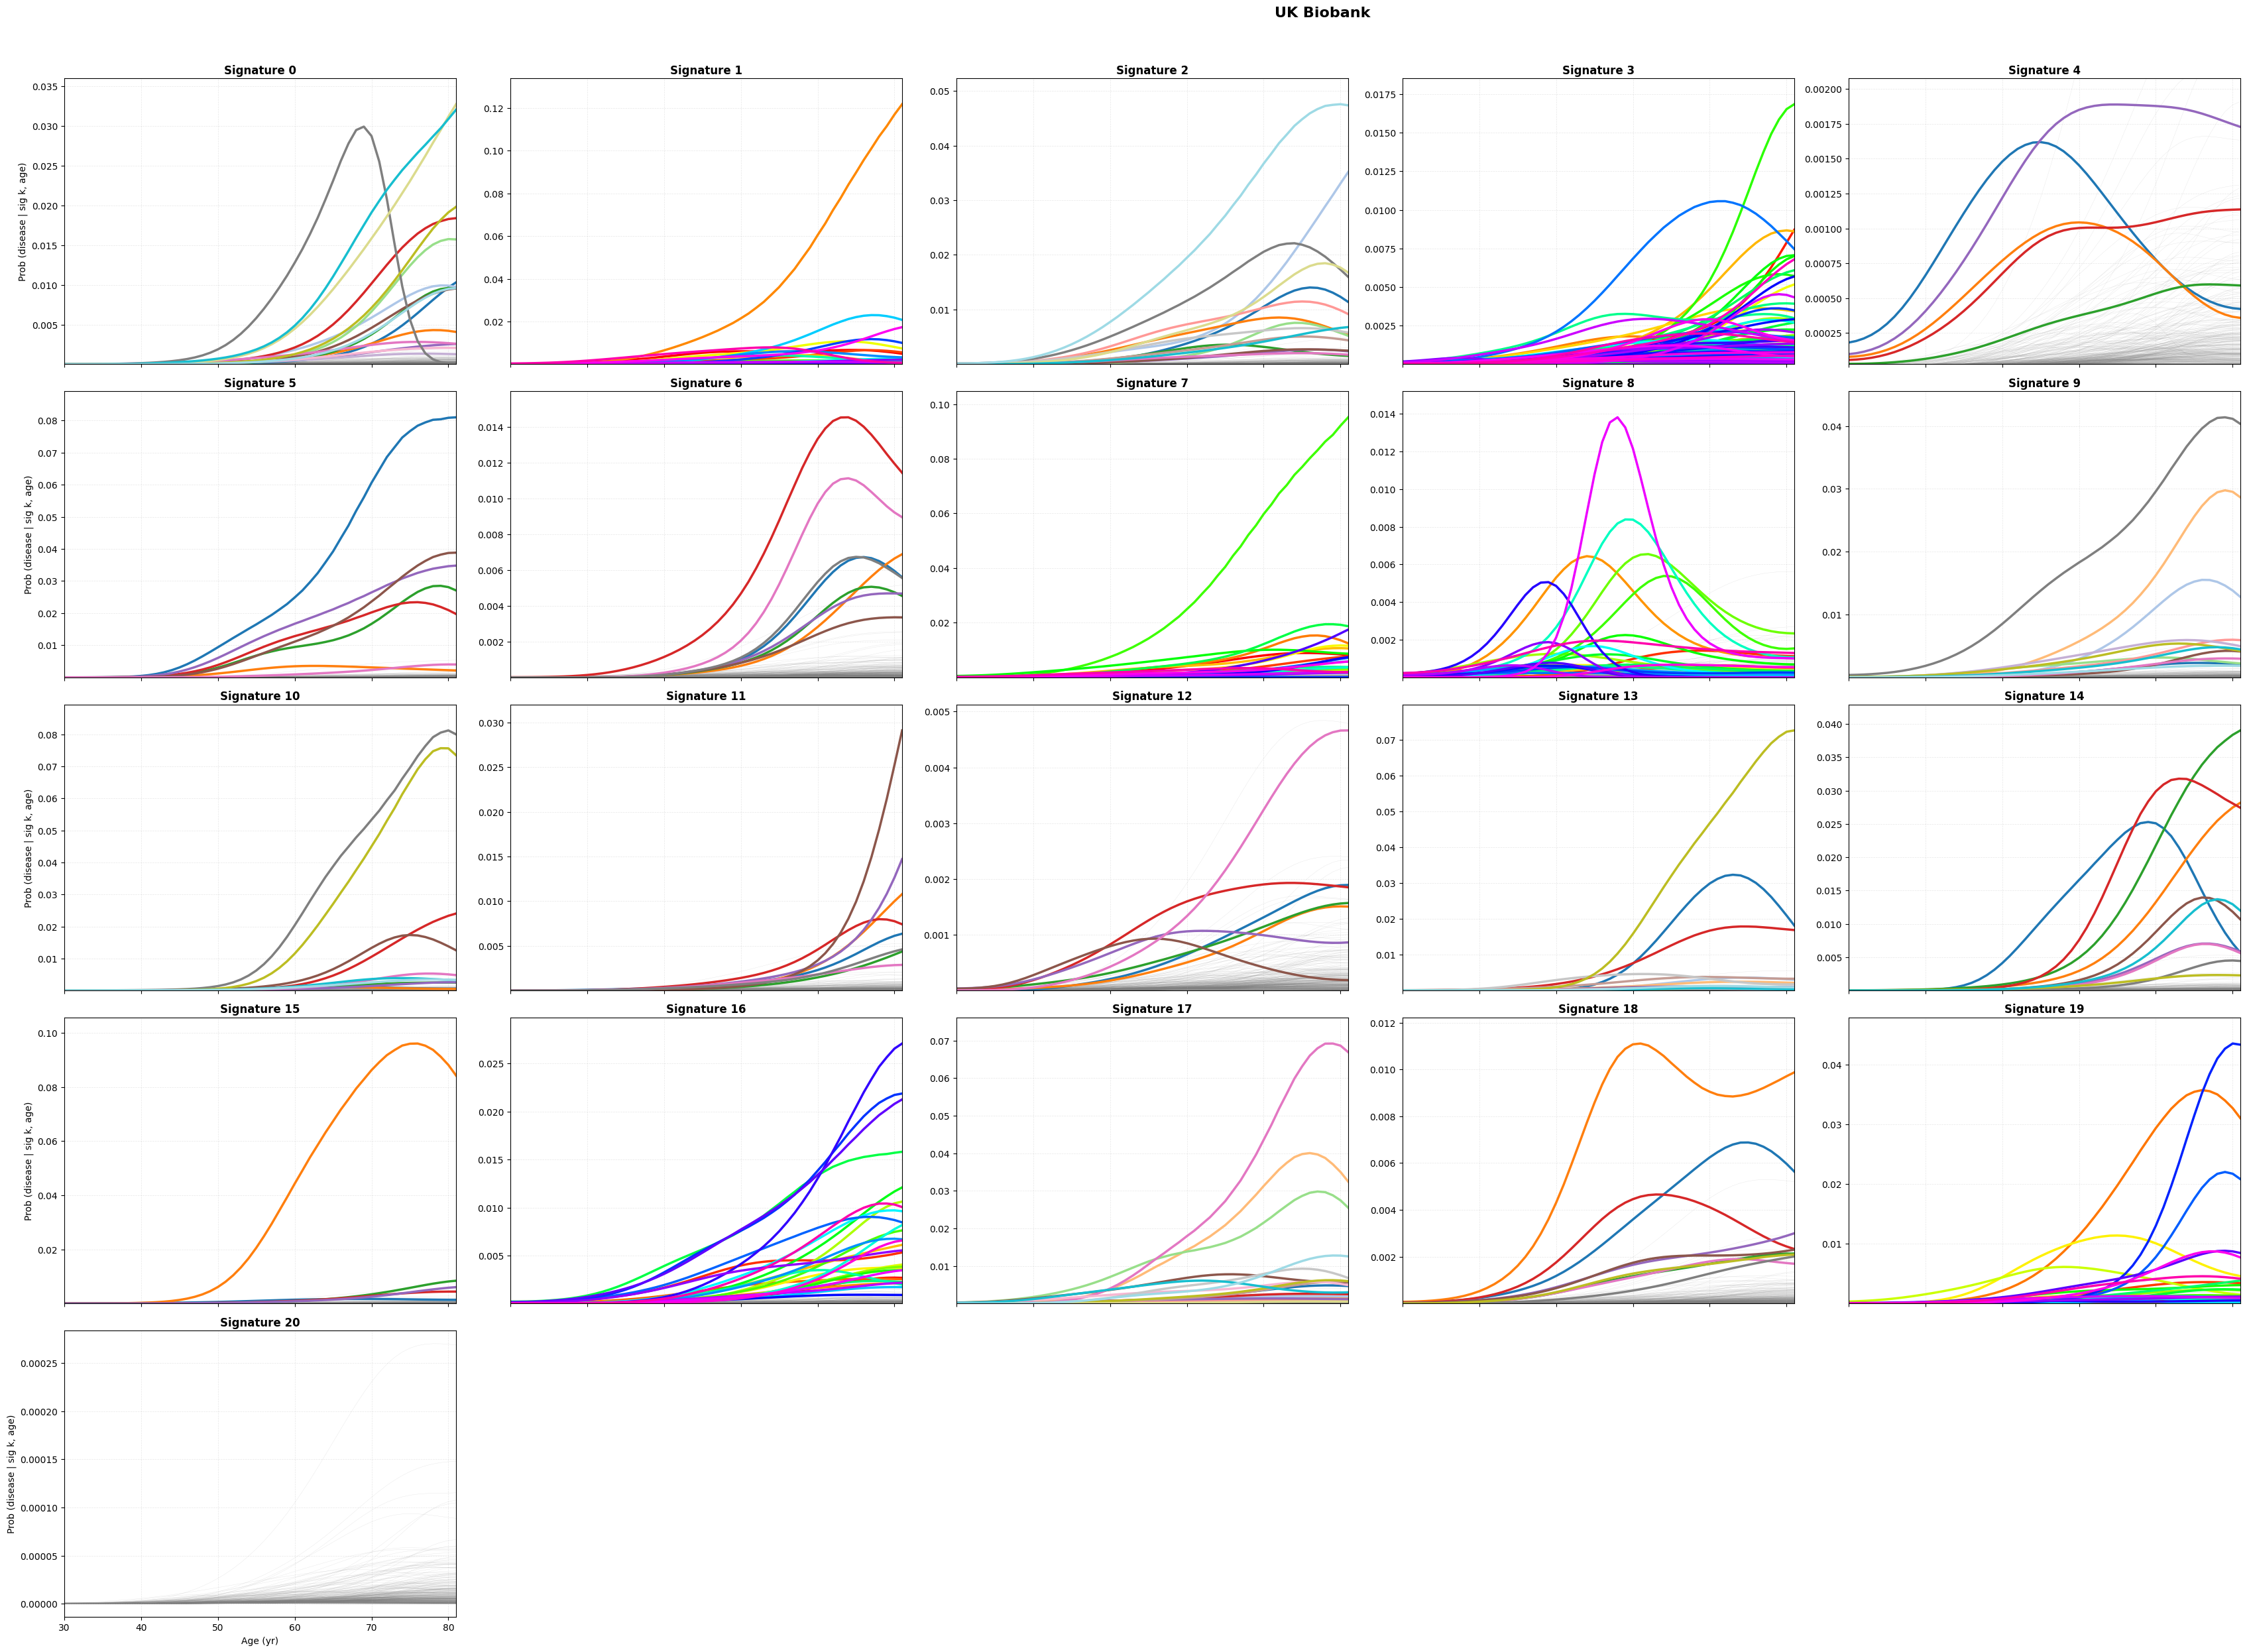


AOU Signature Patterns


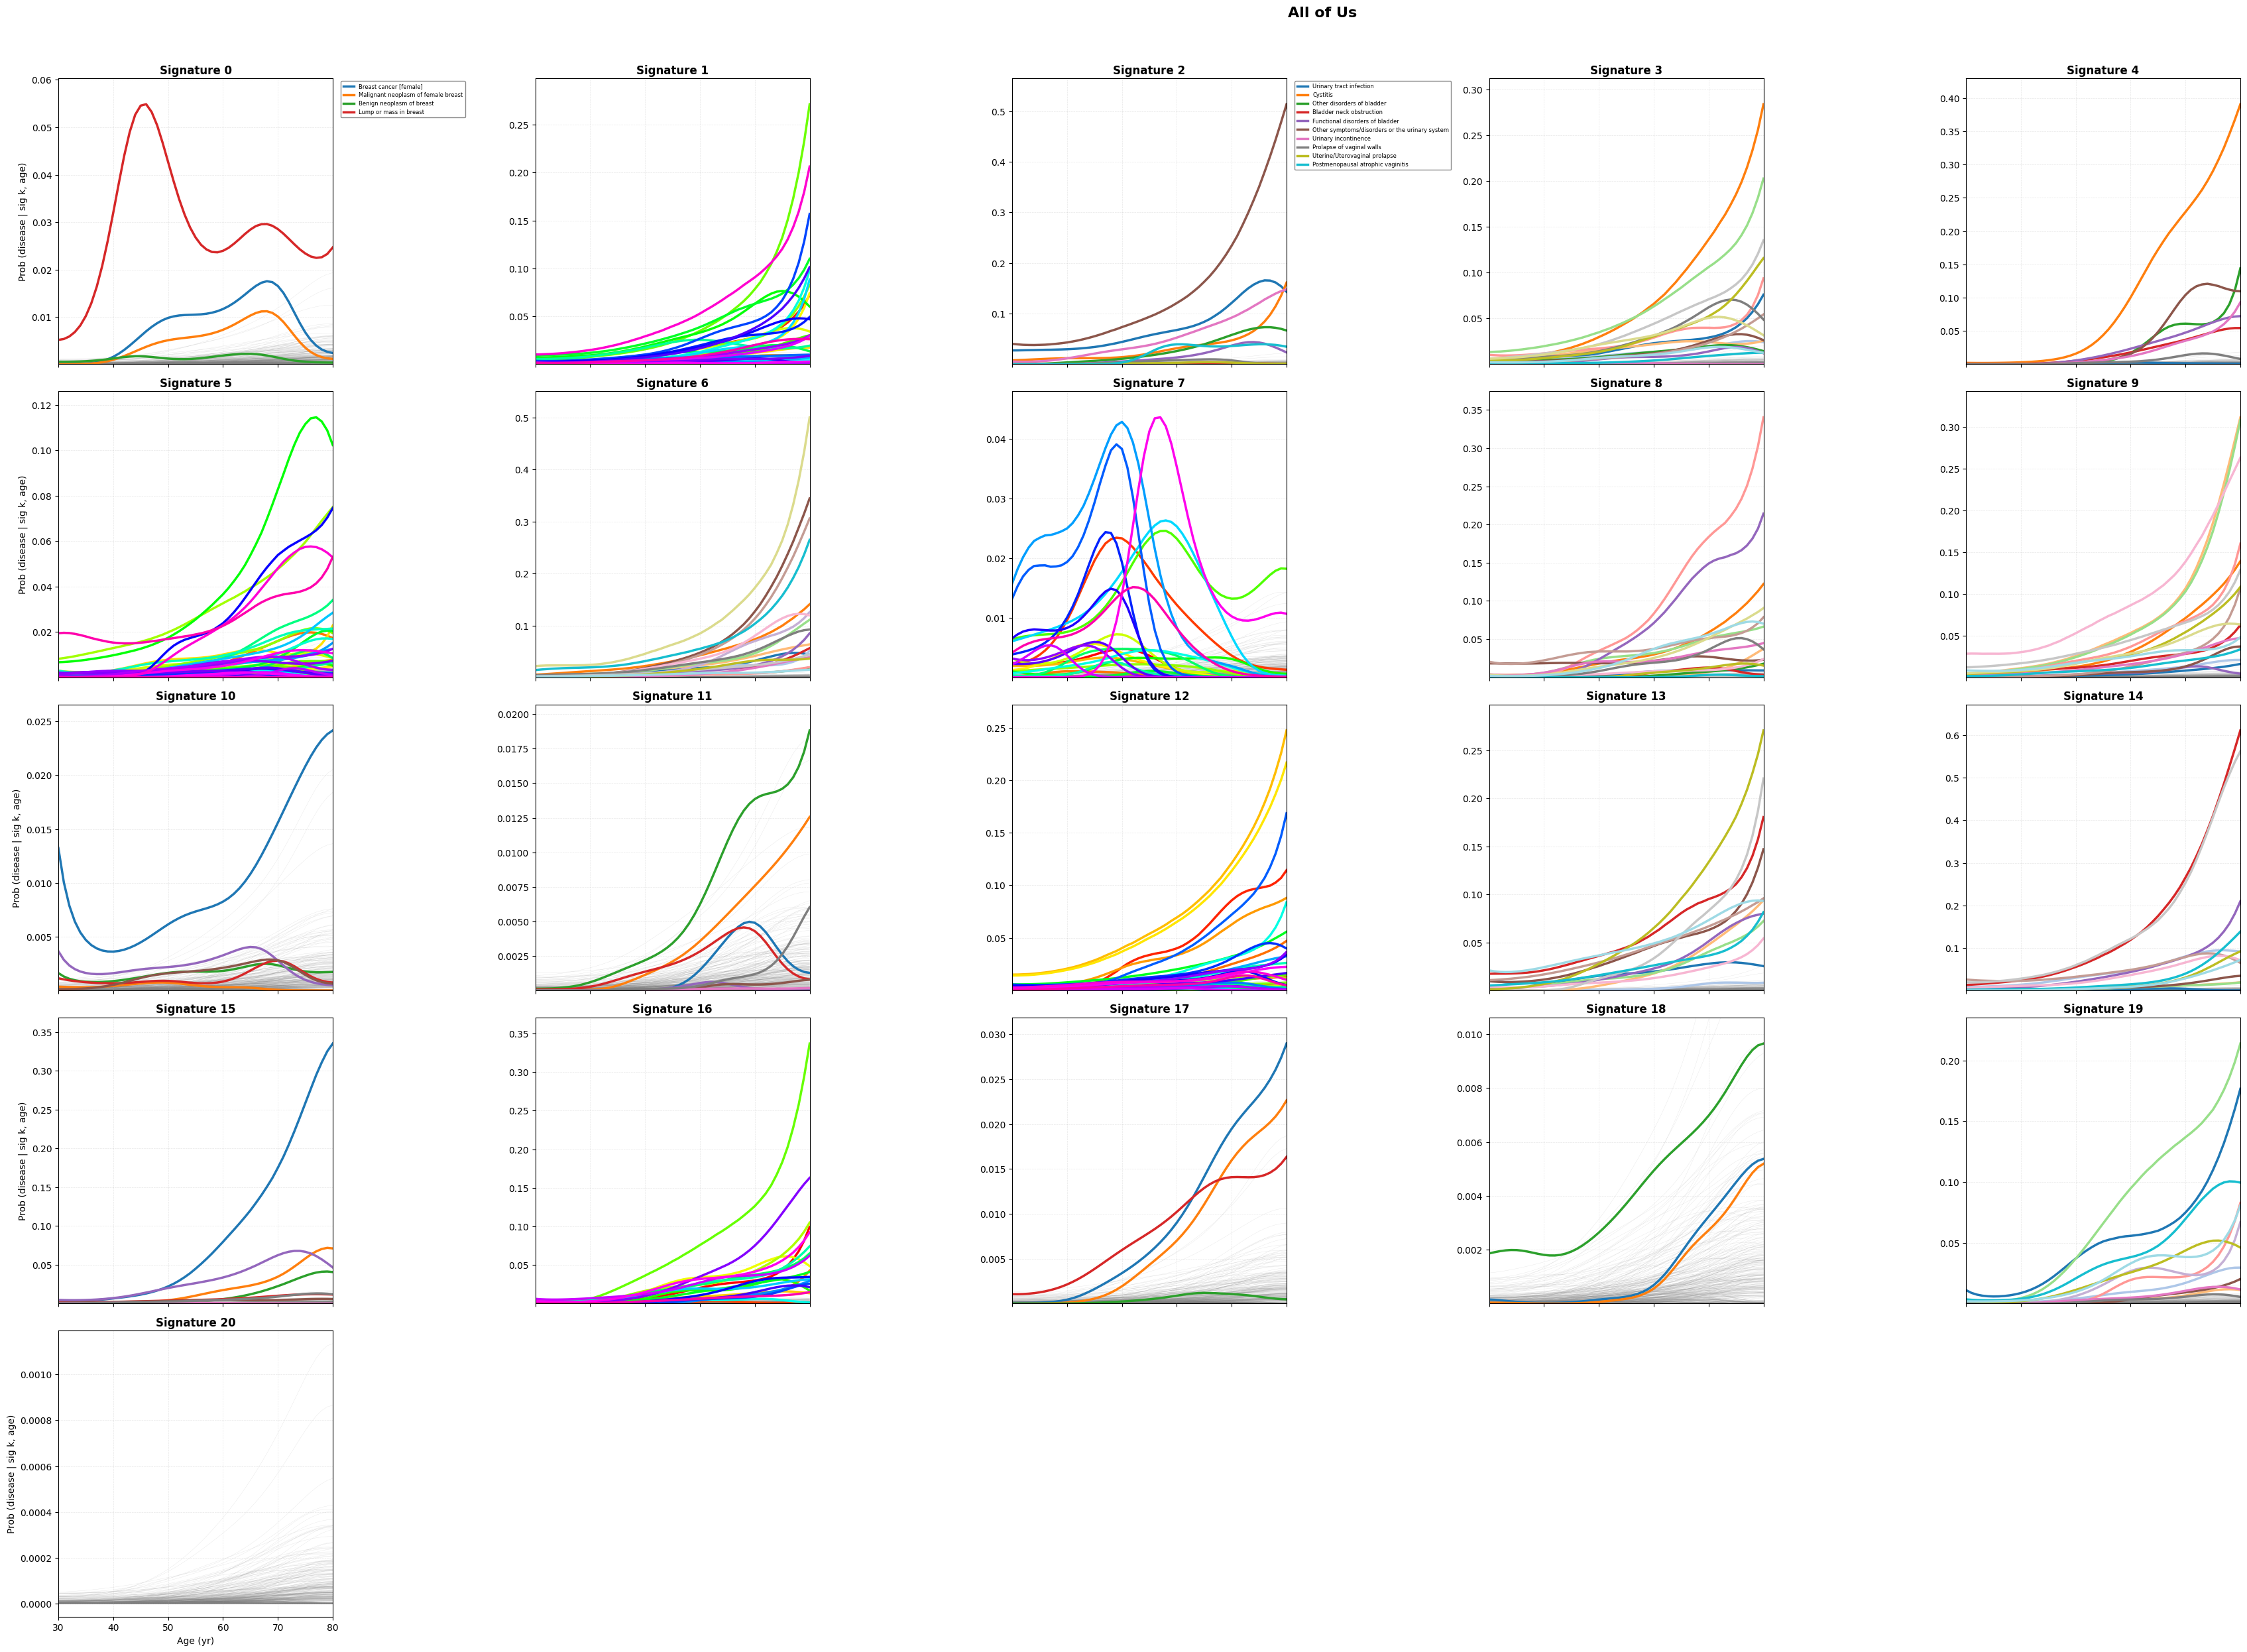


MGB Signature Patterns



✓ All signature plots generated!


In [1]:
# Reload the module to get the updated function

# Load all three trained models
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts')
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


print("Loading model checkpoints...")

# UKB: master checkpoint with pooled phi
ukb_master = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_correctedE.pt', map_location='cpu')
ukb_phi = ukb_master['model_state_dict']['phi']
if torch.is_tensor(ukb_phi):
    ukb_phi = ukb_phi.detach().cpu().numpy()

# AOU: trained model
aou_checkpoint = torch.load('/Users/sarahurbut/aladynoulli2/aou_model_initialized.pt', map_location='cpu')
aou_phi = aou_checkpoint['model_state_dict']['phi']
if torch.is_tensor(aou_phi):
    aou_phi = aou_phi.detach().cpu().numpy()

# MGB: trained model
mgb_checkpoint = torch.load('/Users/sarahurbut/aladynoulli2/mgb_model_initialized.pt', map_location='cpu')
mgb_phi = mgb_checkpoint['model_state_dict']['phi']
if torch.is_tensor(mgb_phi):
    mgb_phi = mgb_phi.detach().cpu().numpy()

# Load clusters and disease names for each cohort
# UKB
ukb_checkpoint_ref = torch.load('/Users/sarahurbut/Dropbox-Personal/model_with_kappa_bigam.pt', map_location='cpu')
ukb_clusters = ukb_checkpoint_ref['clusters']
if torch.is_tensor(ukb_clusters):
    ukb_clusters = ukb_clusters.detach().cpu().numpy()
ukb_disease_names = ukb_checkpoint_ref['disease_names']
if isinstance(ukb_disease_names, (list, tuple)):
    ukb_disease_names = list(ukb_disease_names)
elif hasattr(ukb_disease_names, 'values'):
    ukb_disease_names = ukb_disease_names.values.tolist()

# AOU
aou_clusters = aou_checkpoint['clusters']
if torch.is_tensor(aou_clusters):
    aou_clusters = aou_clusters.detach().cpu().numpy()
aou_disease_names = aou_checkpoint.get('disease_names', None)
if aou_disease_names is None:
    # Try to load from old checkpoint
    aou_old = torch.load('/Users/sarahurbut/Dropbox-Personal/model_with_kappa_bigam_aou_psi12.pt', map_location='cpu')
    aou_disease_names = aou_old.get('disease_names', [f"Disease_{i}" for i in range(aou_phi.shape[1])])
if isinstance(aou_disease_names, (list, tuple)):
    aou_disease_names = list(aou_disease_names)
elif hasattr(aou_disease_names, 'values'):
    aou_disease_names = aou_disease_names.values.tolist()

# MGB
mgb_clusters = mgb_checkpoint['clusters']
if torch.is_tensor(mgb_clusters):
    mgb_clusters = mgb_clusters.detach().cpu().numpy()
mgb_disease_names = mgb_checkpoint.get('disease_names', None)
if mgb_disease_names is None:
    # Try to load from old checkpoint
    mgb_old = torch.load('/Users/sarahurbut/Dropbox-Personal/model_with_kappa_bigam_MGB.pt', map_location='cpu')
    mgb_disease_names = mgb_old.get('disease_names', [f"Disease_{i}" for i in range(mgb_phi.shape[1])])
if isinstance(mgb_disease_names, (list, tuple)):
    mgb_disease_names = list(mgb_disease_names)
elif hasattr(mgb_disease_names, 'values'):
    mgb_disease_names = mgb_disease_names.values.tolist()

print(f"UKB: phi shape {ukb_phi.shape}, clusters shape {ukb_clusters.shape}, {len(ukb_disease_names)} diseases")
print(f"AOU: phi shape {aou_phi.shape}, clusters shape {aou_clusters.shape}, {len(aou_disease_names)} diseases")
print(f"MGB: phi shape {mgb_phi.shape}, clusters shape {mgb_clusters.shape}, {len(mgb_disease_names)} diseases")

# Determine number of signatures (should be 15 for all)
n_sigs = min(ukb_phi.shape[0], aou_phi.shape[0], mgb_phi.shape[0])
selected_sigs = list(range(n_sigs))
print(f"\nPlotting {n_sigs} signatures for each cohort")

import importlib
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures')
from plot_signature_patterns_fixed import *

# Plot UKB signatures
print("\n" + "="*80)
print("UKB Signature Patterns")
print("="*80)
fig_ukb = plot_signature_phi_patterns(
    ukb_phi, ukb_clusters, ukb_disease_names,
    selected_signatures=selected_sigs,
    top_n_diseases=None,  # Show all diseases in each signature
    plot_probability=True,  # Convert to probability
    age_offset=30
)
plt.suptitle('UK Biobank', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 0.85, 0.98])
plt.show()

# Plot AOU signatures
print("\n" + "="*80)
print("AOU Signature Patterns")
print("="*80)
fig_aou = plot_signature_phi_patterns(
    aou_phi, aou_clusters, aou_disease_names,
    selected_signatures=selected_sigs,
    top_n_diseases=None,  # Show all diseases in each signature
    plot_probability=True,  # Convert to probability
    age_offset=30
)
plt.suptitle('All of Us', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 0.85, 0.98])
plt.show()

# Plot MGB signatures
print("\n" + "="*80)
print("MGB Signature Patterns")
print("="*80)
fig_mgb = plot_signature_phi_patterns(
    mgb_phi, mgb_clusters, mgb_disease_names,
    selected_signatures=selected_sigs,
    top_n_diseases=None,  # Show all diseases in each signature
    plot_probability=True,  # Convert to probability
    age_offset=30
)
plt.suptitle('MGB', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 0.85, 0.98])
plt.show()

print("\n✓ All signature plots generated!")


## 4. Conclusion: Censoring Bias, Not Competing Risks

### Summary:

1. **The Problem**: The original model showed decreasing hazards at older ages, which the reviewer correctly identified as concerning

2. **The Root Cause**: This was **censoring bias**, not competing risks:
   - The E matrix assumed all patients were followed until age 81
   - In reality, many patients were censored earlier (see distribution plots above)
   - This created artificial decreases in disease risk at older ages

3. **The Solution**: We implemented a **corrected E matrix** that:
   - Accounts for realistic censoring times (`max_censor - 30`)
   - Uses at-risk filtering for prevalence calculations
   - Results in realistic, continuously increasing disease risk with age

4. **The Evidence**:
   - **Censor distributions** show variable follow-up times across cohorts
   - **Old vs New prevalence** clearly shows the artificial U-shaped pattern in the old model
   - **Old vs New phi** demonstrates that learned patterns match corrected prevalence
   - **Figure 2 signature patterns** show the systematic nature of the problem across multiple signatures and cohorts

### Key Takeaway:

The decreasing hazards at older ages were **not due to competing risks**, but rather **censoring bias** in the original model. The corrected E approach addresses this issue, resulting in biologically realistic disease risk patterns that continue to increase with age, as expected.

### Competing Risks Are Still Handled:

While the decreasing hazards were not due to competing risks, our model **does** handle competing risks appropriately:

- **Multi-disease modeling**: Patients remain at risk for all diseases even after developing one
- **Death as competing event**: Death is modeled as a disease outcome
- **Censoring**: Emigration and administrative censoring are handled through the E matrix

See `R3_Competing_Risks.ipynb` for a detailed discussion of how Aladynoulli handles competing risks.
